# DeMetRA - literature review

This the preprocessing pipeline for the metadata included in the DeMetRA review. Inputs to the pipeline are: 
- The `MPS_review_systematic_DATE.xlsx` file, which contains the metadata manually extracted by Isabel 
- The bibliography file, to supplement more information about the publications included in the review.

In [1]:
import pandas as pd
import numpy as np

assets_directory = '../assets/'

In the file created by Isabel, there are 3 sheets:
1. The main list of MPSs / papers included in the review
2. The base sample references papers for summary statistics 
3. The base sample references papers for validated algorithms 


In [2]:
sys_review_file = 'MPS_review_systematic_2025-05-06.xlsx' # 'MPS_review_systematic_2025-02-14.xlsx'

lit, base_ss, base_va = pd.read_excel(f'{assets_directory}{sys_review_file}', sheet_name=[0, 1, 2]).values()

# lit = lit.loc[lit.Include == 'Yes'].drop('Include', axis=1) # All included

# print(lit.shape, '\n', list(lit.columns))
# print(base_ss.shape, '\n', list(base_ss.columns))
# print(base_va.shape, '\n', list(base_va.columns))


/Users/Serena/Desktop/DEMETRA/DeMetRA-review/demetra_venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/Serena/Desktop/DEMETRA/DeMetRA-review/demetra_venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Merge the two base sample sheets into one.

In [3]:
base_ss.insert(1, 'Base use', 'Summary statistics')
base_va.insert(1, 'Base use', 'Validated algorithm')

# print(base_ss.shape, base_va.shape)

lit_base = pd.concat([base_ss, base_va], axis=0, ignore_index=True, sort=False)

# print(lit_base.shape, '\n', list(lit_base.columns))

### STEP 1 - Data cleaning

In [4]:
from dateutil.parser import parse as parse_date

#### Data inspection and cleaning

To guide manual cleaning of the excel file, I print value counts for the main columns of interest.

In [5]:
# Inspect values 
def checklvl(var):
    allobs = pd.concat([lit[var], base_ss[var], base_va[var]])
    print(allobs.value_counts(dropna=False))

for v in  ['Tissue', 'Array','Ancestry','Developmental_period']:
    checklvl(v)
    print('\n')
    try: 
        checklvl(f'Multiple_{v.lower()}')
        print('\n')
    except:
        pass

# NOTE: this is to guide manual cleaning of the excel file!

Tissue
Peripheral blood          497
Whole blood               153
Saliva                    120
Cord blood                 48
Dried bloodspot            26
Blood-clots                26
Buccal cells               21
Placenta                   15
Nasal epithelial cells      7
Tumour cells                7
Multiple                    4
Leukocytes                  4
Not reported                1
Cervical cells              1
Name: count, dtype: int64


Multiple_tissue
NaN                            926
Whole blood, HPCs                2
Cord blood, Dried bloodspot      1
Cord blood, Whole blood          1
Name: count, dtype: int64


Array
Multiple    436
EPICv1      289
450K        191
WGBS         14
Name: count, dtype: int64


Multiple_array
NaN                                    494
450K, EPICv1                           426
450K, GMEL (~3000 CpGs from EPICv1)      6
450K, EPICv2                             2
450K, EPICv3                             1
450K, EPICv4                     

Extract and remove the "_multiple" 'Tissue', 'Array', and 'Ancestry' columns so that only one column is kept in the dataset. I do this for both the main list and the base samples.

In [6]:
# Recode "multiple" categories
def replace_multiples(df, drop_multiple_cols=True):

    for var in ['Tissue', 'Array', 'Ancestry']:
    
        if var == 'Ancestry':
            df.loc[df[var] == 'Multiple', var] = 'Mixed'
    
        else:
            df.loc[df[var] == 'Multiple', var] = [f'Multiple ({values})' for values in df.loc[df[var] == 'Multiple', f'Multiple_{var.lower()}']]
        
        # print(df[var].value_counts(), '\n')
    
        if drop_multiple_cols:
            df.drop([f'Multiple_{var.lower()}'], axis=1, inplace=True)

    return df

lit = replace_multiples(lit)
lit_base = replace_multiples(lit_base)

Removing 2 scores that have Number of CpGs == 0 because they did not identify a solution. 


In [7]:
lit = lit[lit['Number of CpGs'] != 0].reset_index(drop=True)

Clean the number of CpGs column by replacing "NA" with base sample sizes and setting "Not reported" to NA. 

In [8]:
print(lit["Number of CpGs"].isna().sum(), 'NA values')

# na_nCpGs_baseID = lit.loc[lit['Number of CpGs'].isna(), 'Identifier_base']
# lit_base.loc[lit_base['Identifier'].isin(na_nCpGs_baseID), ['Identifier','Phenotype','Number of CpGs']]

for idx, row in lit.iterrows():
    if pd.isna(row['Number of CpGs']):
        # Find the corresponding row in lit_base
        match = lit_base[
            (lit_base['Identifier'] == row['Identifier_base']) &
            (lit_base['Phenotype'] == row['Phenotype'])
        ]
        # If a match is found, update the 'Number of CpGs' value
        if match.empty:
            print(row['Identifier_base'], row['Phenotype'], 'not found')
        else:
            lit.at[idx, 'Number of CpGs'] = match.iloc[0]['Number of CpGs']


43 NA values


In [9]:
print(lit["Number of CpGs"].isna().sum(), 'NA values')
print(lit.loc[lit["Number of CpGs"]=='Not reported',].shape[0], '"Not reported" values') 

lit['n CpGs'] = pd.to_numeric(lit['Number of CpGs'], errors='coerce')

# Check coerced values (all NA == "Not reported")
# coerced_mask = lit['n CpGs'].isna() & lit['Number of CpGs'].notna()
# lit.loc[coerced_mask & (lit['Number of CpGs'] != 'Not reported'), ].shape[0]

0 NA values
325 "Not reported" values


In [10]:
print(lit_base["Number of CpGs"].isna().sum(), 'NA values')
print(lit_base.loc[lit_base["Number of CpGs"]=='Not reported',].shape[0], '"Not reported" values') 

lit_base['n CpGs'] = pd.to_numeric(lit_base['Number of CpGs'], errors='coerce')

# Check coerced values
coerced_mask = lit_base['n CpGs'].isna() & lit_base['Number of CpGs'].notna()
print('\nProblematic values (coerced to NA)')
lit_base.loc[coerced_mask & (lit_base['Number of CpGs'] != 'Not reported'), 'Number of CpGs'] # .shape[0]


20 NA values
16 "Not reported" values

Problematic values (coerced to NA)


67     194-196
68      51-176
112    118-148
121     82-107
122     82-107
Name: Number of CpGs, dtype: object

Clean the "Sample size" columns so that they are all numeric

In [11]:
# Transform sample size to numeric -----------------------------------------------
lit['Sample size'] = pd.to_numeric(lit['Sample_size_total'], errors='coerce')

lit['n Cases'] = pd.to_numeric(lit['Sample_size_case'], errors='coerce')
lit['n Controls'] = pd.to_numeric(lit['Sample_size_control'], errors='coerce')

def check_coerced(old_var, new_var, df=lit):
    # Check the coerced values
    coerced_mask = df[new_var].isna() & df[old_var].notna()
    coerced_values = df.loc[coerced_mask, old_var].value_counts()
    if coerced_values.shape[0] > 0:
        print('\nThese values are coerced to NA:\n', coerced_values)

check_coerced('Sample_size_total', 'Sample size')
check_coerced('Sample_size_case', 'n Cases')
check_coerced('Sample_size_control', 'n Controls')


These values are coerced to NA:
 Sample_size_total
Unclear    5
>1000      1
Name: count, dtype: int64

These values are coerced to NA:
 Sample_size_case
Not reported    6
Name: count, dtype: int64

These values are coerced to NA:
 Sample_size_control
Not reported    6
Unclear         5
>1000           1
Name: count, dtype: int64


In [12]:
lit_base['Sample size'] = pd.to_numeric(lit_base['Sample_size_total'], errors='coerce')

lit_base['n Cases'] = pd.to_numeric(lit_base['Sample_size_case'], errors='coerce')
lit_base['n Controls'] = pd.to_numeric(lit_base['Sample_size_control'], errors='coerce')

check_coerced('Sample_size_total', 'Sample size', df=lit_base)
check_coerced('Sample_size_case', 'n Cases', df=lit_base)
check_coerced('Sample_size_control', 'n Controls', df=lit_base)

####  Bibliography file
I additionally parse the bibliography file for publication dates, abstracts and keywords

In [13]:
# Parsing bibliography file (this shoud be a RIS or TXT file in RIS format)

ris_tags = {
    'TY': 'Reference Type',
    'AU': 'Author_list',
    'PY': 'Year',
    'TI': 'Title', # 'T1
    'T2': 'Journal', # 'JO'
    'J2': 'Journal', # For pre-prints 
    'AB': 'Abstract',
    'DO': 'DOI',
    'UR': 'URL',
    'KW': 'Keywords',
    'DA': 'Date'
}

def parse_ris(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        references = []

        current_entry = {}
        current_tag = None

        for line in file:
            if not line.strip():  # Skip empty lines
                continue
            elif line.strip() == 'ER  -':  # ER marks the end of the record
                # Append reference and reset
                references.append(current_entry)
                current_entry = {}
                current_tag = None 
            else:
                tag = line[:5]

                if tag in [f'{t}  -' for t in ris_tags.keys()]:
                    current_tag = tag

                    value = line[5:].strip()
                    key = ris_tags[tag[:2]]

                    if key in current_entry:
                        if isinstance(current_entry[key], list):
                            current_entry[key].append(value)
                        else:
                            current_entry[key] = [current_entry[key], value]
                    else:
                        current_entry[key] = value

                # Handle dates that span multiple lines
                elif tag in [f'{y}-' for y in range(2000, 2025)]:
                    value = line.strip()
                    if 'Date' not in current_entry:
                        current_entry['Date'] = value # Only keep first occurrance (i.e. publication date)

                # Handle keywords that span multiple lines
                else:
                    if current_tag == 'KW  -':
                        value = line.strip()
                        if isinstance(current_entry['Keywords'], list):
                            current_entry['Keywords'].append(value)
                        else:
                            current_entry['Keywords'] = [current_entry['Keywords'], value]
                                    
        return references


parsed_data = parse_ris(f'{assets_directory}Bibliography_2024-09-19.txt')
bib = pd.DataFrame(parsed_data)[['Author_list', 'Year', 'Title', 'Journal', 'Keywords', 'Abstract', 
                                 'Date', 'DOI', 'URL']]

print(bib.shape)
bib.head(2)


(323, 9)


,Author_list,Year,Title,Journal,Keywords,Abstract,Date,DOI,URL
0,"[Abrishamcar, S., Chen, J., Feil, D., Kilanows...",2022,DNA methylation as a potential mediator of the...,Transl Psychiatry,NaN,Prenatal tobacco exposure (PTE) and prenatal a...,09 30,10.1038/s41398-022-02195-3,http://dx.doi.org/10.1038/s41398-022-02195-3
1,"[Ács, O., Péterfia, B., Hollósi, P., Luczay, A...",2017,Methylation Status of CYP27B1 and IGF2 Correla...,Obes Facts,"[25 hydroxyvitamin D, bisulfite, cytochrome P4...",Objective: Worldwide increasing childhood obes...,2017-08-16,10.1159/000477462,https://www.embase.com/search/results?subactio...


In [14]:
# Clean bibliography file

# Only selected papers ----------------------------------------------------------------
bib_incl = bib.loc[bib.Title.isin(lit.Title.unique()), ].reset_index(drop=True)
# bib_incl.shape

# Correct dates ----------------------------------------------------------------------- 
print('Note', bib_incl.Date.isna().sum(), 'NaN Date values will be set to 01/01 of respective year')

date_tmp = pd.Series([' '.join([d, y]) if y not in d else d for d, y in 
                   zip(bib_incl.Date.map(str), bib_incl.Year.map(str))])

bib_incl.loc[:, 'Date'] = date_tmp.apply(lambda date: 
                                         parse_date(date).strftime('%Y-%m-%d') if 'nan' not in date else 
                                         parse_date('01 01' + date[3:]).strftime('%Y-%m-%d'))

# Get Short Author titles ------------------------------------------------------------
bib_incl['Author'] = [f'{fa[0].split(",")[0]} et al.' if len(fa) > 1 else f'{fa[0].split(",")[0]}' 
                            for fa in bib_incl['Author_list']]


# Fix missing Journal names ----------------------------------------------------------
bib_incl.loc[bib_incl.DOI.str.contains('10.3390/toxics9100262', na=False), 
             'Journal'] = 'Toxics'
bib_incl.loc[bib_incl.DOI.str.contains('10.1007/s00787-024-02390-1', na=False), 
             'Journal'] = 'Eur Child Adolesc Psych'
bib_incl.loc[bib_incl.DOI.str.contains('10.3390/ijms22031111|10.3390/ijms22168611', na=False), 
             'Journal'] = 'Int J Mol Sci'

# bib_incl.head(3)


Note 9 NaN Date values will be set to 01/01 of respective year


In [15]:
print(lit.shape)

lit_main = lit.rename(columns={'Author': 'Author_dirty',
                               'Journal': 'Journal_dirty'}).merge(bib_incl,
                     on='Title', how='left', suffixes=['','_BIB'])

# CHECKUPS 
# lit_main[['Author','Author_list','Author_dirty']]
# np.where(lit_main['Year'].map(int) != lit_main['Year_BIB'].map(int))
# pd.set_option('display.max_rows', None)
# lit_main.loc[lit_main['DOI'].map(str) != lit_main['DOI_BIB'].map(str), ['Title','DOI','DOI_BIB']]

# Clean Journal names ----------------------------------------------------------------
lit_main['Journal'] = lit_main['Journal'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Clean DOI values -------------------------------------------------------------------
lit_main['DOI_BIB'] = lit_main['DOI_BIB'].fillna(lit_main['DOI'])
lit_main['DOI'] = lit_main['DOI_BIB']
lit_main.drop(['DOI_BIB','Year_BIB'], axis=1, inplace=True)

(758, 41)


#### Rename and reorder

In [16]:
# Rename columns
rename_cols_dict = {'What_is_available': 'Based on',
                    'Sample_type': 'Sample type',
                    'Developmental_period': 'Developmental period',
                    'Type': 'Publication type',}

lit_main = lit_main.rename(columns=rename_cols_dict)  
lit_base = lit_base.rename(columns=rename_cols_dict)

# print(lit_main.columns)

lit_base.drop(['Sample_size_case', 'Sample_size_control', 'Sample_size_total', 'Number of CpGs'], axis=1, inplace=True)

# Dropping 'Author_dirty', 'Journal_dirty','Include', 'pdf','Link', 

mps_table = lit_main[['Phenotype', 'Category', 'Author', 'Year', 'Title', 'DOI',
                      'n CpGs', 'Based on', 'Sample size', 'n Cases', 'n Controls',
                      'Sample type', 'Developmental period', 'Tissue', 'Array', 'Ancestry',
                      'Identifier', 'Publication type', 'Journal', 'Keywords', 'Abstract', 'Author_list', 'Date', 'URL',
                      'Including_CpGs_1', 'Including_CpGs_2', 'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5',
                      'Identifier_base', 'Multiple_identifier_base', 'Sample_overlap_target_base',
                      'Determining_weights_1', 'Train_test', 'Independent_validation', 'Comparison', 'Missing_value_note',
                      'Reflect_phenotype','Covariates']]

# Save cleaned data ------------------------------------------------------------------
# lit_main.to_csv(f'{assets_directory}MPS_literature_cleaned.csv', index=False)

In [17]:
pd.set_option('display.max_columns', None)
print(mps_table.shape)
mps_table.head(1)

(758, 39)


,Phenotype,Category,Author,Year,Title,DOI,n CpGs,Based on,Sample size,n Cases,n Controls,Sample type,Developmental period,Tissue,Array,Ancestry,Identifier,Publication type,Journal,Keywords,Abstract,Author_list,Date,URL,Including_CpGs_1,Including_CpGs_2,Including_CpGs_3,Including_CpGs_4,Including_CpGs_5,Identifier_base,Multiple_identifier_base,Sample_overlap_target_base,Determining_weights_1,Train_test,Independent_validation,Comparison,Missing_value_note,Reflect_phenotype,Covariates
0,Prenatal alcohol exposure,Lifestyle and environment,Abrishamcar et al.,2022,DNA methylation as a potential mediator of the...,10.1038/s41398-022-02195-3,NaN,EWAS summary statistics,262.0,NaN,NaN,Population-based,Birth,Cord blood,"Multiple (450K, EPICv1)",African,1,Journal Article,Transl Psychiatry,NaN,Prenatal tobacco exposure (PTE) and prenatal a...,"[Abrishamcar, S., Chen, J., Feil, D., Kilanows...",2022-09-30,http://dx.doi.org/10.1038/s41398-022-02195-3,Association DNAm phenotype | Multiple p-values...,Pruning | CoMeBack,NaN,NaN,NaN,Sharp (2018) - Maternal alcohol consumption an...,NaN,No,Discovery EWAS | Linear regression,No,No,No,Not reported,Reported | Explained variance | R = 0.0006,"maternal age, maternal HIV status, maternal de..."


#### Publications table 
Create a  table grouped by "paper" rather than by "MPS"

In [18]:
# Aggregate rows so that a list is returned when there are multiple values in the same "paper group"
def aggregate_values(series):

    # Keywords and Author_list contain lists, which are not hashable but also do not change across papers
    if series.apply(lambda x: isinstance(x, list)).sum() > 0: 
        return series.iloc[0]
    
    unique_values = series.unique()
    if len(unique_values) == 1:
        return unique_values[0]
    else:
        return list(unique_values)

# Group by 'Title' and apply the aggregation function 
pub_table = mps_table.groupby('Title').agg(aggregate_values).reset_index()
n_MPS = mps_table.Title.value_counts() 
for t in n_MPS.index:
    pub_table.loc[pub_table.Title == t, 'n MPSs'] = int(n_MPS[t])

In [19]:
print(pub_table.shape)

# reorder columns
pub_table = pub_table[['Author', 'Year', 'Title', 'DOI', 'Phenotype', 'Category', 
                      'n MPSs', 'n CpGs', 'Based on', 'Sample size', 'n Cases', 'n Controls',
                      'Sample type', 'Developmental period', 'Tissue', 'Array', 'Ancestry',
                      'Identifier', 'Publication type', 'Journal', 'Keywords', 'Abstract', 'Author_list', 
                      'Date', 'URL','Including_CpGs_1','Including_CpGs_2','Including_CpGs_3','Including_CpGs_4','Including_CpGs_5',
                      'Identifier_base','Multiple_identifier_base','Sample_overlap_target_base',
                      'Determining_weights_1','Train_test','Independent_validation','Comparison','Missing_value_note',
                      'Reflect_phenotype','Covariates']]
pub_table.head(1)

(89, 40)


,Author,Year,Title,DOI,Phenotype,Category,n MPSs,n CpGs,Based on,Sample size,n Cases,n Controls,Sample type,Developmental period,Tissue,Array,Ancestry,Identifier,Publication type,Journal,Keywords,Abstract,Author_list,Date,URL,Including_CpGs_1,Including_CpGs_2,Including_CpGs_3,Including_CpGs_4,Including_CpGs_5,Identifier_base,Multiple_identifier_base,Sample_overlap_target_base,Determining_weights_1,Train_test,Independent_validation,Comparison,Missing_value_note,Reflect_phenotype,Covariates
0,Awamleh et al.,2024,A new blood DNA methylation signature for Kool...,10.1038/s41431-024-01538-6,Koolen de Vreis syndrome (KDVS),Genetic syndromes,1.0,456.0,Only phenotype,30.0,8.0,22.0,Case control,Childhood and adolescence,Peripheral blood,EPICv1,Not reported,12,Journal Article,Eur J Hum Genet,"[adult, article, child, clinical article, cont...",Pathogenic variants in KANSL1 and 17q21.31 mic...,"[Awamleh, Z., Choufani, S., Wu, W., Rots, D., ...",2024-01-31,https://www.embase.com/search/results?subactio...,Association DNAm phenotype | Fixed p-value | F...,Association DNAm phenotype | Actual change in ...,NaN,NaN,NaN,NaN,NaN,NaN,Machine learning | Support vector machine,No,Yes (n = 208),No,No,No actual number reported,"Age, sex cell-type"


#### Save cleaned files

In [20]:
lit_base.to_csv(f'{assets_directory}MPS_base_samples_cleaned.csv', index=False)
mps_table.to_csv(f'{assets_directory}MPS_table_cleaned.csv', index=False)
pub_table.to_csv(f'{assets_directory}Publication_table_cleaned.csv', index=False)

### STEP 2 - Descriptives

In [21]:
mps_table = pd.read_csv(f'{assets_directory}MPS_table_cleaned.csv')
pub_table = pd.read_csv(f'{assets_directory}Publication_table_cleaned.csv')

### General descriptives 

In [22]:
print('Total number of publications:', pub_table.shape[0])
print('Total number of unique MPSs:', mps_table.shape[0])

pubs_count = mps_table.groupby('Based on')['Title'].nunique().reset_index().set_index('Based on')

# Add a column for the percentage of all titles
pubs_count['%'] = round((pubs_count['Title'] /  pub_table.shape[0]) * 100, 1)

# NOTE: this has more total publications because some have more than 1 value for what_is_available
print('\n', pub_table['Based on'].value_counts())

pubs_count 

Total number of publications: 89
Total number of unique MPSs: 758

 Based on
Only phenotype                                            54
Validated MPS algorithm                                   17
EWAS summary statistics                                    9
['EWAS summary statistics', 'Validated MPS algorithm']     4
['Only phenotype', 'Validated MPS algorithm']              2
['EWAS summary statistics', 'Only phenotype']              1
['Validated MPS algorithm', 'Only phenotype']              1
['Validated MPS algorithm', 'EWAS summary statistics']     1
Name: count, dtype: int64


,Title,%
Based on,,
EWAS summary statistics,15,16.9
Only phenotype,58,65.2
Validated MPS algorithm,25,28.1


In [23]:
print(pub_table['n MPSs'].describe())

counts = pub_table['n MPSs'].value_counts().sort_index(ascending=True)
percent = counts / counts.sum() * 100

n_MPS_count = counts.to_frame(name='count')
n_MPS_count['%'] = percent.apply(lambda x: f"{x:.1f}%")

print('\n', round(100 - sum(percent.iloc[0:10])), "% of publications report more than 10 MPSs.")

n_MPS_count.T


count     89.000000
mean       8.516854
std       31.453831
min        1.000000
25%        1.000000
50%        1.000000
75%        5.000000
max      278.000000
Name: n MPSs, dtype: float64

 16 % of publications report more than 10 MPSs.


n MPSs,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,14.0,15.0,18.0,19.0,25.0,44.0,104.0,278.0
count,48,11,3,4,1,2,1,3,1,1,3,3,2,1,1,1,1,1,1
%,53.9%,12.4%,3.4%,4.5%,1.1%,2.2%,1.1%,3.4%,1.1%,1.1%,3.4%,3.4%,2.2%,1.1%,1.1%,1.1%,1.1%,1.1%,1.1%


In [24]:
pheno_count = mps_table.Phenotype.value_counts()

n_pheno = len(pheno_count)

pheno_count_rep = pheno_count[pheno_count > 1]

n_pheno_rep = len(pheno_count_rep)

print('Total umber of phenotypes:', n_pheno)
print('Number of phenotypes with more than one MPS:', n_pheno_rep, '(', round(n_pheno_rep / n_pheno * 100), '%)')

pheno_count_rep[pheno_count_rep > 9]


Total umber of phenotypes: 324
Number of phenotypes with more than one MPS: 146 ( 45 %)


Phenotype
Maternal smoking          49
Asthma                    14
Allergy                   14
Kabuki syndrome           14
Atopic status             12
Externalizing behavior    12
BMI                       10
Internalizing behavior    10
Sotos syndrome            10
Name: count, dtype: int64

In [25]:
def get_count_percent(variable, data=mps_table, precision=0, print_count=True):
    counts = pd.DataFrame(data[variable].value_counts())
    _total = counts.sum()
    
    counts['%'] = round((counts / _total) * 100, precision)

    # Some row indexes will be lists which are not hashable
    counts.index = counts.index.map(lambda x: str(x) if isinstance(x, list) else x)

    print('\n')
    for idx, row in counts.iterrows():
        fmtcount = int(row['count']) if print_count else ''
        fmtpercent = int(row['%']) if precision == 0 else row['%']
        print(f"{idx} {fmtcount} ({fmtpercent}%)")


In [26]:
get_count_percent('Based on')



Only phenotype 475 (63%)
Validated MPS algorithm 200 (26%)
EWAS summary statistics 83 (11%)


In [27]:
get_count_percent('Category')
get_count_percent('Category', data=pub_table)



Biological markers 394 (52%)
Genetic syndromes 185 (24%)
Lifestyle and environment 81 (11%)
Physical health indicators 59 (8%)
Neuro-psychiatric health indicators 34 (4%)
Cancer 5 (1%)


Genetic syndromes 45 (51%)
Lifestyle and environment 17 (19%)
Biological markers 7 (8%)
Neuro-psychiatric health indicators 6 (7%)
Cancer 5 (6%)
Physical health indicators 4 (4%)
['Physical health indicators', 'Lifestyle and environment'] 2 (2%)
['Lifestyle and environment', 'Biological markers'] 1 (1%)
['Lifestyle and environment', 'Neuro-psychiatric health indicators', 'Physical health indicators'] 1 (1%)
['Physical health indicators', 'Neuro-psychiatric health indicators'] 1 (1%)


In [28]:
print('MPS count')
get_count_percent('Category', precision=1)
print('\nPhenotype count\n', mps_table.groupby('Category')['Phenotype'].nunique())
print('\nPublication count\n', mps_table.groupby('Category')['Title'].nunique())

mps_table[['Category', 'Phenotype']].value_counts().sort_index()

MPS count


Biological markers 394 (52.0%)
Genetic syndromes 185 (24.4%)
Lifestyle and environment 81 (10.7%)
Physical health indicators 59 (7.8%)
Neuro-psychiatric health indicators 34 (4.5%)
Cancer 5 (0.7%)

Phenotype count
 Category
Biological markers                     182
Cancer                                   5
Genetic syndromes                      103
Lifestyle and environment               18
Neuro-psychiatric health indicators     10
Physical health indicators               6
Name: Phenotype, dtype: int64

Publication count
 Category
Biological markers                      8
Cancer                                  5
Genetic syndromes                      45
Lifestyle and environment              21
Neuro-psychiatric health indicators     8
Physical health indicators              8
Name: Title, dtype: int64


Category                    Phenotype      
Biological markers          ADA                 3
                            ADAMTS              1
                            ARTN                3
                            AXIN1               3
                            Adiponectin         1
                                               ..
Physical health indicators  Asthma             14
                            Atopic status      12
                            BMI                10
                            Birth weight        6
                            Health problems     3
Name: count, Length: 324, dtype: int64

In [29]:
# Check that each phenotype is always assigned to the same category
mps_table.groupby('Phenotype')['Category'].nunique().sort_values(ascending=False).head(2)

Phenotype
uPA                          1
16p11.2 deletion syndrome    1
Name: Category, dtype: int64

In [30]:
get_count_percent("Tissue") #, print_count=False)



Peripheral blood 457 (60%)
Saliva 120 (16%)
Cord blood 45 (6%)
Whole blood 35 (5%)
Dried bloodspot 26 (3%)
Blood-clots 26 (3%)
Buccal cells 20 (3%)
Placenta 13 (2%)
Nasal epithelial cells 6 (1%)
Tumour cells 4 (1%)
Leukocytes 3 (0%)
Not reported 1 (0%)
Cervical cells 1 (0%)
Multiple (Whole blood, HPCs) 1 (0%)


In [31]:
mps_table['Tissue'].astype(str).value_counts(dropna=False)

Tissue
Peripheral blood                457
Saliva                          120
Cord blood                       45
Whole blood                      35
Dried bloodspot                  26
Blood-clots                      26
Buccal cells                     20
Placenta                         13
Nasal epithelial cells            6
Tumour cells                      4
Leukocytes                        3
Not reported                      1
Cervical cells                    1
Multiple (Whole blood, HPCs)      1
Name: count, dtype: int64

In [32]:
a = sum([
457, # Peripheral blood 457 (60%)
35, # Whole blood 35 (5%)
45, # Cord blood 45 (6%)
26, # Dried bloodspot 26 (3%)
26, # Blood-clots 26 (3%)
3 # Leukocytes 3 (0%)
])

b = sum([
120, # Saliva 120 (16%)
20 # Buccal cells 20 (3%)
])

c = sum([
13, # Placenta 13 (2%)
6, # Nasal epithelial cells 6 (1%)
4, # Tumour cells 4 (1%)
1 # Cervical cells 1 (0%)
])

d = 1 # Multiple (Whole blood, HPCs) 1 (0%)

1# Not reported 1 (0%)

for n in [a, b, c, d]:
    print(f'{n} ({round(n / mps_table.shape[0] * 100, 1)}%)')


592 (78.1%)
140 (18.5%)
24 (3.2%)
1 (0.1%)


In [33]:
get_count_percent("Sample type")

get_count_percent("Sample type", data=pub_table)



Population-based 394 (52%)
Case control 193 (25%)
Cohort study 120 (16%)
Twin study 21 (3%)
Convenience sample 18 (2%)
Randomized controlled trial 12 (2%)


Case control 48 (54%)
Population-based 24 (27%)
Cohort study 11 (12%)
Twin study 3 (3%)
Convenience sample 2 (2%)
Randomized controlled trial 1 (1%)


In [34]:
# pd.set_option('display.max_columns', None)
# # lit_main.loc[lit_main['Array'] == "WGBS",]

get_count_percent("Array")

get_count_percent("Array", data=pub_table)



Multiple (450K, EPICv1) 393 (52%)
EPICv1 281 (37%)
450K 63 (8%)
WGBS 14 (2%)
Multiple (450K, GMEL (~3000 CpGs from EPICv1)) 6 (1%)
Multiple (450K, EPICv2) 1 (0%)


EPICv1 53 (60%)
450K 18 (20%)
Multiple (450K, EPICv1) 12 (13%)
['450K', 'EPICv1'] 2 (2%)
WGBS 1 (1%)
['EPICv1', '450K'] 1 (1%)
['Multiple (450K, GMEL (~3000 CpGs from EPICv1))', '450K'] 1 (1%)
['Multiple (450K, EPICv1)', 'Multiple (450K, EPICv2)'] 1 (1%)


In [35]:
get_count_percent("Ancestry", precision=1)

get_count_percent("Ancestry", precision=1, data=pub_table)



European 380 (50.1%)
Not reported 189 (24.9%)
White 142 (18.7%)
Mixed 44 (5.8%)
African 2 (0.3%)
Hispanic 1 (0.1%)


Not reported 47 (52.8%)
European 25 (28.1%)
Mixed 9 (10.1%)
White 6 (6.7%)
African 1 (1.1%)
Hispanic 1 (1.1%)


In [36]:
get_count_percent("Developmental period", precision=1)

get_count_percent("Developmental period", precision=1, data=pub_table)



Mid childhood 320 (42.2%)
Birth 166 (21.9%)
Childhood and adolescence 125 (16.5%)
Not reported 63 (8.3%)
Late childhood 44 (5.8%)
Adolescence 26 (3.4%)
Very early childhood 11 (1.5%)
Early childhood 3 (0.4%)


Childhood and adolescence 43 (48.3%)
Birth 17 (19.1%)
Adolescence 6 (6.7%)
Not reported 4 (4.5%)
Late childhood 4 (4.5%)
['Adolescence', 'Birth', 'Mid childhood'] 3 (3.4%)
['Adolescence', 'Mid childhood'] 2 (2.2%)
['Late childhood', 'Mid childhood'] 2 (2.2%)
Very early childhood 2 (2.2%)
Mid childhood 2 (2.2%)
Early childhood 1 (1.1%)
['Birth', 'Mid childhood'] 1 (1.1%)
['Childhood and adolescence', 'Early childhood'] 1 (1.1%)
['Not reported', 'Childhood and adolescence'] 1 (1.1%)


In [37]:
get_count_percent('Sample_overlap_target_base')

# get_count_percent('Sample_overlap_target_base', data=pub_table)



No 251 (93%)
Yes 19 (7%)


count       433.000000
mean       2738.713626
std       37165.804126
min           2.000000
25%          37.000000
50%         111.000000
75%         204.000000
max      764525.000000
Name: n CpGs, dtype: float64


<Axes: >

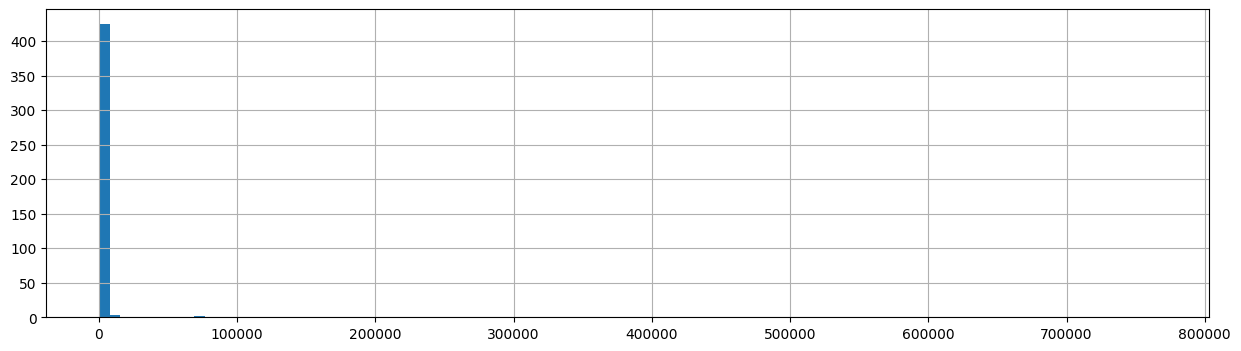

In [38]:
print(mps_table['n CpGs'].describe())

mps_table['n CpGs'].hist(bins=100, figsize=(15, 4))

<Axes: >

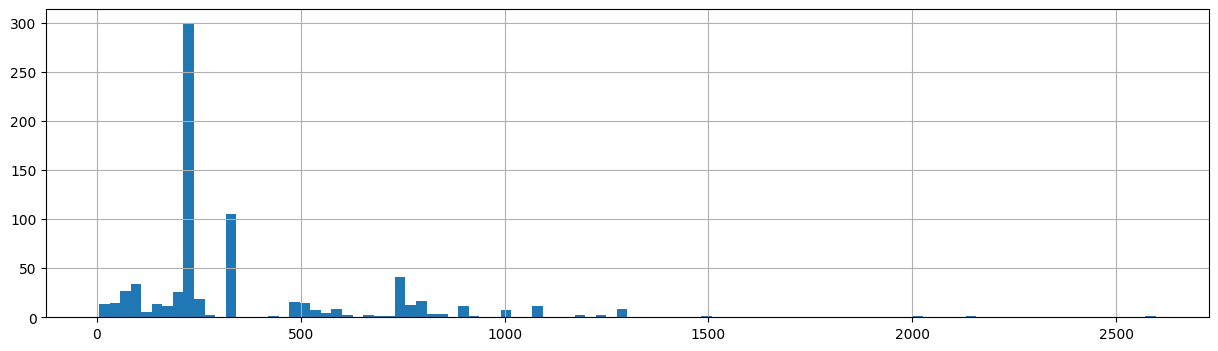

In [39]:
mps_table['Sample size'].describe()

mps_table['Sample size'].hist(bins=100, figsize=(15, 4))


r = -0.047 , P =  0.328


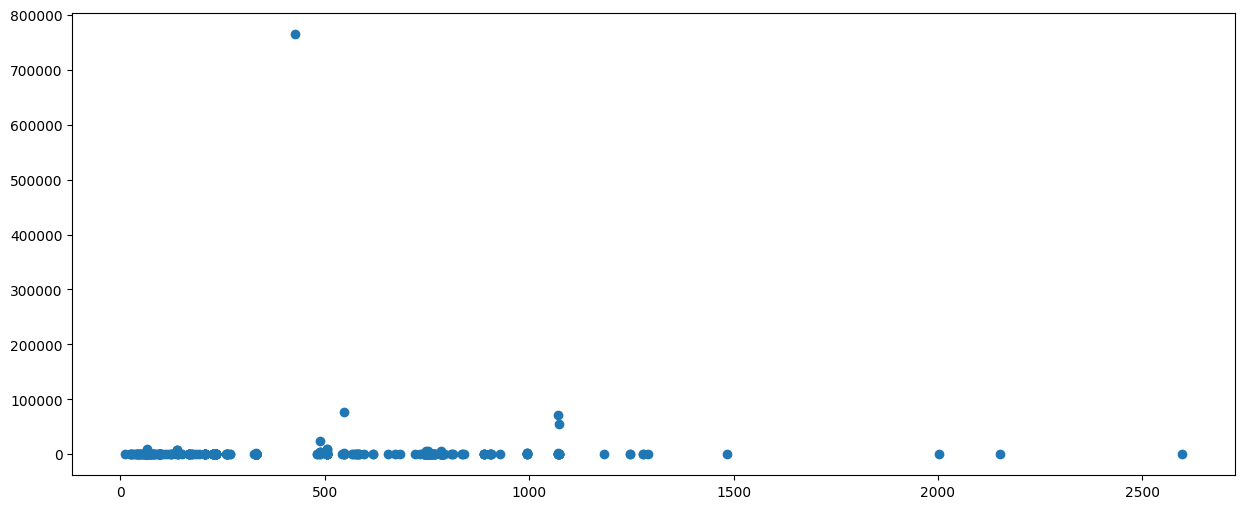

In [40]:
from scipy.stats import spearmanr
r, p = spearmanr(mps_table['Sample size'], mps_table['n CpGs'], nan_policy='omit')

print('r =', round(r, 3), ', P = ', round(p,3))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(mps_table['Sample size'], mps_table['n CpGs'], 'o')


In [41]:
# sample size
# covariates

##### Analytical methods

In [42]:
strategy_count = mps_table[['Including_CpGs_1', 'Including_CpGs_2', 
                            'Including_CpGs_3', 'Including_CpGs_4', 
                            'Including_CpGs_5']].notna().sum(axis=1)
print(strategy_count.describe())

strategy_count = strategy_count.value_counts().sort_index()
percent = (strategy_count / strategy_count.sum() * 100).round(1)
print(pd.DataFrame({'count': strategy_count, '%': percent}))

print(round(percent[2:].sum(),1), '% of MPSs use > 1 strategy to include CpGs in the analysis.')


count    758.000000
mean       1.010554
std        1.491462
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        5.000000
dtype: float64
   count     %
0    460  60.7
1     86  11.3
2     75   9.9
3     21   2.8
4    113  14.9
5      3   0.4
28.0 % of MPSs use > 1 strategy to include CpGs in the analysis.


In [43]:
def summarize_strategies(data=mps_table):
    strategies = ['Including_CpGs_1', 'Including_CpGs_2', 
                  'Including_CpGs_3', 'Including_CpGs_4', 
                  'Including_CpGs_5']
    for strategy in strategies:
        print(strategy, data[strategy].value_counts().sort_index(), '\n')

summarize_strategies()

Including_CpGs_1 Including_CpGs_1
Association DNAm phenotype | Actual change in methylation | 10%                                        7
Association DNAm phenotype | Actual change in methylation | 10-20%                                     8
Association DNAm phenotype | Actual change in methylation | 15%                                        5
Association DNAm phenotype | Actual change in methylation | 20%                                        2
Association DNAm phenotype | Actual change in methylation | 25%                                        1
Association DNAm phenotype | Actual change in methylation | 5%                                         4
Association DNAm phenotype | Actual change in methylation | top ranking 1000                           3
Association DNAm phenotype | Actual change in methylation | top ranking 800                            2
Association DNAm phenotype | Effect size                                                              44
Association DNAm phen

In [44]:
def filter_strategies(strategy, data=mps_table):
    mask = data[['Including_CpGs_1', 'Including_CpGs_2', 
                 'Including_CpGs_3', 'Including_CpGs_4', 
                 'Including_CpGs_5']].apply(lambda col: col.str.contains(
                     strategy, na=False), axis=0).any(axis=1)
    print(f'{data[mask].shape[0]} ({round(data[mask].shape[0] / data.shape[0] * 100, 1)}%)')
    return data[mask]



In [45]:
redundancy = filter_strategies('Pruning')
summarize_strategies(redundancy)

func_annot = filter_strategies('Functional annotation')
summarize_strategies(func_annot)

reproducible = filter_strategies('Reproducibility')
summarize_strategies(reproducible)

for tab_entry in ['Association DNAm phenotype', 'Biological relevance','Pruning','Reproducibility']:
    print('\n', tab_entry)
    filter_strategies(tab_entry)


174 (23.0%)
Including_CpGs_1 Including_CpGs_1
Association DNAm phenotype | Actual change in methylation | 10%                    6
Association DNAm phenotype | Actual change in methylation | 10-20%                 8
Association DNAm phenotype | Actual change in methylation | 15%                    5
Association DNAm phenotype | Actual change in methylation | 20%                    2
Association DNAm phenotype | Actual change in methylation | 25%                    1
Association DNAm phenotype | Actual change in methylation | 5%                     4
Association DNAm phenotype | Actual change in methylation | top ranking 1000       3
Association DNAm phenotype | Actual change in methylation | top ranking 800        2
Association DNAm phenotype | Effect size                                          44
Association DNAm phenotype | Fixed p-value | FDR < .05                             1
Association DNAm phenotype | Fixed p-value | Not reported                         14
Association DNAm ph

In [46]:
stat_sign = filter_strategies('p-value|top-ranking significant probes', data=pub_table)
stat_sign = filter_strategies('top-ranking significant probes')

summarize_strategies(stat_sign)

# stat_sign[['Including_CpGs_1', 'Including_CpGs_2', 'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5']]

70 (78.7%)
133 (17.5%)
Including_CpGs_1 Including_CpGs_1
Association DNAm phenotype | Actual change in methylation | 10%                                        4
Association DNAm phenotype | Actual change in methylation | 15%                                        5
Association DNAm phenotype | Actual change in methylation | 20%                                        2
Association DNAm phenotype | Actual change in methylation | 25%                                        1
Association DNAm phenotype | Actual change in methylation | 5%                                         4
Association DNAm phenotype | Actual change in methylation | top ranking 1000                           3
Association DNAm phenotype | Actual change in methylation | top ranking 800                            2
Association DNAm phenotype | Effect size                                                              44
Association DNAm phenotype | top-ranking significant probes | 100                                      

In [47]:
effect_size = filter_strategies('Actual change in methylation|Effect size|logFC', data=pub_table)
effect_size = filter_strategies('Actual change in methylation|Effect size|logFC')

# effect_size = filter_strategies('Actual change in methylation')

summarize_strategies(effect_size)

# effect_size[['Including_CpGs_1', 'Including_CpGs_2', 'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5']]

24 (27.0%)
91 (12.0%)
Including_CpGs_1 Including_CpGs_1
Association DNAm phenotype | Actual change in methylation | 10%                  7
Association DNAm phenotype | Actual change in methylation | 10-20%               8
Association DNAm phenotype | Actual change in methylation | 15%                  5
Association DNAm phenotype | Actual change in methylation | 20%                  2
Association DNAm phenotype | Actual change in methylation | 25%                  1
Association DNAm phenotype | Actual change in methylation | 5%                   4
Association DNAm phenotype | Actual change in methylation | top ranking 1000     3
Association DNAm phenotype | Actual change in methylation | top ranking 800      2
Association DNAm phenotype | Effect size                                        44
Association DNAm phenotype | Fixed p-value | FDR < .01                           3
Association DNAm phenotype | Fixed p-value | FDR < .05                           2
Association DNAm phenotype | Fi

In [48]:
auc = filter_strategies('AUC', data=pub_table)
auc = filter_strategies('AUC')

# effect_size = filter_strategies('Actual change in methylation')

summarize_strategies(auc)

32 (36.0%)
117 (15.4%)
Including_CpGs_1 Including_CpGs_1
Association DNAm phenotype | Actual change in methylation | 10%                  6
Association DNAm phenotype | Actual change in methylation | 10-20%               8
Association DNAm phenotype | Actual change in methylation | 15%                  5
Association DNAm phenotype | Actual change in methylation | 20%                  2
Association DNAm phenotype | Actual change in methylation | 25%                  1
Association DNAm phenotype | Actual change in methylation | 5%                   4
Association DNAm phenotype | Actual change in methylation | top ranking 1000     3
Association DNAm phenotype | Actual change in methylation | top ranking 800      2
Association DNAm phenotype | Effect size                                        44
Association DNAm phenotype | Fixed p-value | FDR < .01                           2
Association DNAm phenotype | Fixed p-value | Not reported                        1
Association DNAm phenotype | F

In [49]:
print(mps_table.Determining_weights_1.value_counts().sort_index())

def filter_models(model, data=mps_table):
    mask = data['Determining_weights_1'].str.contains(model, na=False)
    print(model)
    print(f'{data[mask].shape[0]} ({round(data[mask].shape[0] / data.shape[0] * 100, 1)}%)')
    return data[mask]

for tab_entry in ['Discovery EWAS', 'Machine learning','Penalized regression']:
    filter_models(tab_entry)



Determining_weights_1
Discovery EWAS | Count (+1 hyper, -1 hypo, based on linear regression)      4
Discovery EWAS | Linear mixed model                                        18
Discovery EWAS | Linear regression                                         76
Discovery EWAS | Survival analyses                                          1
Machine learning | Gradient boosting machine                                4
Machine learning | Naive bayes                                              1
Machine learning | Neural net                                               1
Machine learning | Partial least squares-discriminant analysis              3
Machine learning | Random forest                                           13
Machine learning | Support vector machine                                 130
Penalized regression | ?                                                    5
Penalized regression | Elastic net                                        293
Penalized regression | Lasso              

In [50]:
# Check use of different techniques (dichotomous vs. continuous outcomes)
# mps_table.loc[mps_table.Determining_weights_1 == "Penalized regression | Elastic net", "n Cases"].notna().sum()
# mps_table.loc[(mps_table.Determining_weights_1 == "Machine learning | Support vector machine") & mps_table["n Cases"].isna(), ]

In [51]:
print(mps_table.Sample_overlap_target_base.value_counts().sort_index(),'\n')

print(pub_table.Sample_overlap_target_base.value_counts().sort_index())
# Train_test
# 'Independent_validation', 'Comparison', 'Missing_value_note',
#        'Reflect_phenotype', 'Covariates'

Sample_overlap_target_base
No     251
Yes     19
Name: count, dtype: int64 

Sample_overlap_target_base
No              24
Yes              4
['No', nan]      2
['Yes', nan]     2
[nan, 'No']      3
Name: count, dtype: int64


#### Validation 

In [52]:
no_validation = mps_table.loc[(mps_table.Independent_validation == 'No') & (mps_table.Train_test == 'No'),].shape[0]

print(f'{no_validation} ({round(no_validation / mps_table.shape[0] * 100,1)}%) do not use any validation method')

ext_validation = mps_table.loc[mps_table.Independent_validation.str.contains('Yes', na='ignore'),]
print(f'{ext_validation.shape[0]} ({round(ext_validation.shape[0] / mps_table.shape[0] * 100,1)}%) MPSs perform external validation')

int_validation = mps_table.loc[(mps_table.Train_test != 'No') & (mps_table.Train_test.notna()),]
print(f'{int_validation.shape[0]} ({round(int_validation.shape[0] / mps_table.shape[0] * 100,1)}%) MPSs perform internal validation')

249 (32.8%) do not use any validation method
162 (21.4%) MPSs perform external validation
494 (65.2%) MPSs perform internal validation


In [53]:
get_count_percent('Train_test')
# print(pub_table.Train_test.value_counts().sort_index())



5-fold cross-validation 264 (35%)
No 261 (35%)
Split 25/75%, 10-fold cross-validation 75 (10%)
10-fold cross-validation 42 (6%)
Split 25/75%, leave-25%-out cross-validation, leave-one-out cross-validation 19 (3%)
Cross-validation 15 (2%)
Yes 15 (2%)
Split 25/75%, leave-one-out cross-validation 10 (1%)
Split 20/80%, 50 hold outs 9 (1%)
Split 20/80% 8 (1%)
Split 15/85% 6 (1%)
Split 27/73% 6 (1%)
80/20 train/test + Cross-validation within training 4 (1%)
Split 25/75%, cross-validation 3 (0%)
Split 25/75% 3 (0%)
80/20 train/test 2 (0%)
Split 20/80%, leave-one-out cross-validation 1 (0%)
leave-one-out cross-validation, split 25/75% 1 (0%)
4-fold cross-validation 1 (0%)
Split 67/33%, leave-one-out cross-validation 1 (0%)
Split 20/80%, 10-fold cross-validation 1 (0%)
Split 40/60% 1 (0%)
Split 25/75%, 5-fold cross-validation 1 (0%)
Split 35/65%, 10-fold cross-validation 1 (0%)
Split 25/75%, leave-one-out cross-validation, leave-25%-out cross-validation 1 (0%)
Split 25/75%, 10-fold cross-vali

In [54]:
print(mps_table.Comparison.value_counts().sort_index(),'\n')

print(pub_table.Comparison.value_counts().sort_index())

Comparison
No     672
Yes     86
Name: count, dtype: int64 

Comparison
No               79
Yes               9
['Yes', 'No']     1
Name: count, dtype: int64


In [55]:
print(mps_table.Missing_value_note.value_counts().sort_index(),'\n')

print(pub_table.Missing_value_note.value_counts().sort_index())

Missing_value_note
Common CpGs                                                                    4
Common CpGs, complete case analyses                                            1
Complete case analyses                                                         1
Complete cases and common CpGs                                                 6
Excluding missing probes                                                       1
Imputation | ImputePCA                                                        18
Imputed | missForest                                                           1
Liberal site inclusion to mitigate missingness                                14
Mean imputation                                                                5
Mean imputation, overlapping sites                                             3
No                                                                            94
No missings                                                                    4
Not repor

In [56]:
print(mps_table.Reflect_phenotype.value_counts().sort_index(),'\n')

print(pub_table.Reflect_phenotype.value_counts().sort_index())

Reflect_phenotype
No actual number reported             81
Not assesed                          107
Not assessed                          34
Not assessed                          19
Not reported                          42
                                    ... 
Reported | t-test | t=2.80,p=.003      1
Reported | t-test | t=2.99,p=.001      1
Reported | t-test | t=3.09,p=.001      1
Reported | t-test | t=3.31,p<.001      1
not assessed                          15
Name: count, Length: 361, dtype: int64 

Reflect_phenotype
No actual number reported                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [57]:
print(mps_table.Covariates.value_counts().sort_index(),'\n')

print(pub_table.Covariates.value_counts().sort_index())

Covariates
 Five technical\nvariables were included in the model: sample plate batch, sentrix position\non the chip, granulocyte cell estimate, red blood cell estimate, and CD8 T\ncell estimate [25, 42]). Also, clinical characteristics such as maternal age at\ndelivery, BMI before pregnancy, maternal place of birth (Scandinavia or other), educational level (University degree yes or no), mode of delivery (vaginal, vacuum extraction, emergency cesarean section, and elective cesarean section), parity, and gestational age, based on previous literature [15, 26, 43–45], were also included in the model, in total 12 covariates                                                                                                                                                                                                                                                            3
Age, sex cell-type                                                                                                      

In [58]:
pub_table.columns

Index(['Author', 'Year', 'Title', 'DOI', 'Phenotype', 'Category', 'n MPSs',
       'n CpGs', 'Based on', 'Sample size', 'n Cases', 'n Controls',
       'Sample type', 'Developmental period', 'Tissue', 'Array', 'Ancestry',
       'Identifier', 'Publication type', 'Journal', 'Keywords', 'Abstract',
       'Author_list', 'Date', 'URL', 'Including_CpGs_1', 'Including_CpGs_2',
       'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5',
       'Identifier_base', 'Multiple_identifier_base',
       'Sample_overlap_target_base', 'Determining_weights_1', 'Train_test',
       'Independent_validation', 'Comparison', 'Missing_value_note',
       'Reflect_phenotype', 'Covariates'],
      dtype='object')

### Number of  Publications / MPSs per year

In [59]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Verdana"]

/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_15314/1660861394.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f0.set_xticklabels([int(x) for x in f0.get_xticks()], rotation=60)


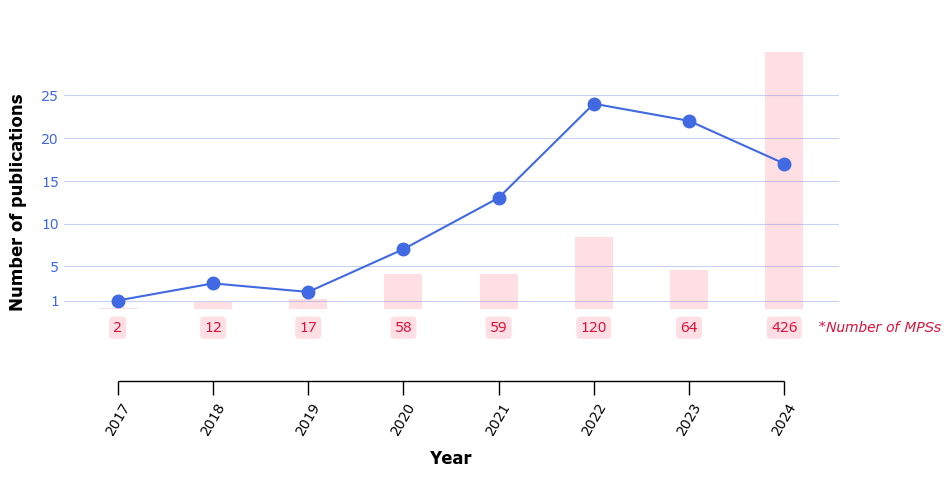

In [60]:
f0 = mps_table.groupby('Year').Title.nunique().plot(figsize=(10, 5), marker ='o', ms = 9, color='royalblue')

f0.set_xticklabels([int(x) for x in f0.get_xticks()], rotation=60)

f0.set_yticks([1]+[int(x) for x in range(5, 26, 5)])

# Set bin edges (1-year bins)
years = mps_table['Year']
min_year, max_year = years.min(), years.max()

# Histogram counts
counts, bin_edges = np.histogram(years, bins=np.arange(mps_table['Year'].min(), 
                                                       mps_table['Year'].max() + 2))  # +2 to include the last year

# Scale counts to match 0-30 range to fit it on the same plot
max_count = counts.max()
scaled_counts = counts * (30 / max_count) if max_count > 0 else counts

nmps_bars = f0.bar(bin_edges[:-1],  # center the bars
                   scaled_counts,
                   width=0.4, color='pink', alpha=0.5, edgecolor=None, zorder=1, align='center')

for bar, count in zip(nmps_bars, counts):

    # Annotate each bar with the original count
    f0.text(bar.get_x() + bar.get_width()/2, 
            -3, # bar.get_height()+5, 
            str(count),
            ha='center', va='bottom', color='crimson', fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.3',    # Rounded corners with padding
                      facecolor='pink', edgecolor='none', alpha=0.5))
    
f0.text(2025, -3, '*Number of MPSs', ha='center', va='bottom', fontsize=10, color='crimson', fontdict={'fontstyle':'italic'})

# Remove axes spines
for spine in f0.spines.values():
    spine.set_visible(False)

# Adjust y-axis 
f0.set_ylim(-10, 35)
f0.tick_params(axis='y', length=0, labelcolor='royalblue', labelsize=10)
f0.set_ylabel('Number of publications', fontsize=12, fontweight='bold', labelpad=10)
f0.grid(axis='y', color='royalblue', alpha=0.3)

# Adjust x-axis
f0.tick_params(axis='x', length=10, width=1, direction='in', color='black')
f0.hlines(-8.4, 2016.999, 2024, colors='black', linewidth=1)
f0.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=10)

f0.figure.savefig(f'../static_output/Figure0_MPS-pubs-per-year.png', dpi=300, bbox_inches='tight')

### Publication network graph 

In [61]:
import ast
import networkx as nx
import pickle

In [62]:
G = nx.Graph()

for pub in pub_table.Title:             
    title = f"Paper/{pub.replace(':', ' ')}"
    authors = ast.literal_eval(pub_table.loc[pub_table.Title==pub, 'Author_list'].iloc[0])
    for author in authors:
        author = f"Author/{author.replace('. ', '.')}" # remove space between multiple initials   
        G.add_edge(author, title)


In [63]:
# Estimate optimal node positions ----------------------------------------------------
# pos = nx.spring_layout(G, seed=3108, k=1000)
pos = nx.fruchterman_reingold_layout(G, seed=3108, k=0.05)

# Assign 'pos' attribute to the nodes in the graph
for node in G.nodes:
    G.nodes[node]['pos'] = pos[node]

# G.nodes


In [64]:
# Save the graph object to a file since it takes a few seconds to compute on the fly 
with open(f'{assets_directory}/Publications_network.pkl', 'wb') as file:
    pickle.dump(G, file)

In [65]:
with open(f'{assets_directory}/Publications_network.pkl', 'rb') as file:
    G = pickle.load(file)

### Merge base and target info 

In [66]:
d_base = pd.read_csv(f'{assets_directory}MPS_base_samples_cleaned.csv')

d_targ = mps_table.loc[mps_table['Based on'] != 'Only phenotype',]

print(d_targ.shape, d_base.shape)

(283, 39) (170, 30)


In [67]:
multi_base = d_targ.loc[d_targ.Identifier_base == "Multiple",]

multi_base_pubs = multi_base.Title.unique()
print(multi_base.shape[0], 'MPSs, from', len(multi_base_pubs), 'publications have multiple base samples.')

print(multi_base['Based on'].value_counts())

# TMP: remove them for now 
print('Removing them for now')
print(d_targ['Multiple_identifier_base'].value_counts())

d_targ = d_targ.loc[d_targ.Identifier_base != "Multiple",]

d_targ.shape

7 MPSs, from 2 publications have multiple base samples.
Based on
EWAS summary statistics    7
Name: count, dtype: int64
Removing them for now
Multiple_identifier_base
Xu (2021) - Shared DNA methylation signatures in; Reese (2019) - Epigenome-wide meta-analysis of; Qi (2020) - Nasal DNA methylation profiling of               6
Liu (2018) - A DNA methylation biomarker of; Dugue (2019) - Alcohol consumption is associated with; Carreras-Gallo (2023) - Impact of tobacco, alcohol, and    1
Name: count, dtype: int64


(276, 39)

In [68]:
d_base['MPS_id'] = d_base['Identifier'] + d_base['Phenotype']
d_targ['MPS_id'] = d_targ['Identifier_base'] + d_targ['Phenotype']
# d_targ = d_targ.rename(columns={'Identifier_base': 'Identifier'})

common_ids = set(d_base['MPS_id']) & set(d_targ['MPS_id'])
unique_to_base = set(d_base['MPS_id']) - set(d_targ['MPS_id'])
unique_to_targ = set(d_targ['MPS_id']) - set(d_base['MPS_id'])

print(len(common_ids), "matching ids\n")
print(len(unique_to_base), "unique to base")
[print(p) for p in unique_to_base]
print(len(unique_to_targ), "unique to targ")
# print(unique_to_targ)

# d_targ.loc[~d_targ.Multiple_identifier_base.isna(),]

162 matching ids

4 unique to base
Qi (2020) - Nasal DNA methylation profiling ofAsthma and rihinitis
Liu (2018) - A DNA methylation biomarker ofAlcohol consumption
Dugue (2019) - Alcohol consumption is associated withAlcohol consumption
Carreras-Gallo (2023) - Impact of tobacco, alcohol, andAlcohol consumption
0 unique to targ


In [69]:
d_targ_base = d_targ.merge(d_base, on='MPS_id', how='left', suffixes=[' - targ',' - base'])

print(sorted(d_targ_base.columns))
d_targ_base.shape

# Save cleaned data ------------------------------------------------------------------
d_targ_base.to_csv(f'{assets_directory}MPS_base_target_cleaned.csv', index=False)

['Abstract', 'Ancestry - base', 'Ancestry - targ', 'Array - base', 'Array - targ', 'Author', 'Author_list', 'Base use', 'Based on - base', 'Based on - targ', 'Category - base', 'Category - targ', 'Comparison - base', 'Comparison - targ', 'Covariates - base', 'Covariates - targ', 'DOI', 'Date', 'Determining_weights_1 - base', 'Determining_weights_1 - targ', 'Developmental period - base', 'Developmental period - targ', 'Identifier - base', 'Identifier - targ', 'Identifier_base - base', 'Identifier_base - targ', 'Including_CpGs_1 - base', 'Including_CpGs_1 - targ', 'Including_CpGs_2 - base', 'Including_CpGs_2 - targ', 'Including_CpGs_3 - base', 'Including_CpGs_3 - targ', 'Including_CpGs_4 - base', 'Including_CpGs_4 - targ', 'Including_CpGs_5 - base', 'Including_CpGs_5 - targ', 'Independent_test', 'Independent_validation', 'Journal', 'Keywords', 'Link', 'MPS_id', 'Missing_value_note - base', 'Missing_value_note - targ', 'Multiple_identifier_base - base', 'Multiple_identifier_base - targ', 

In [70]:
mps_table.columns

Index(['Phenotype', 'Category', 'Author', 'Year', 'Title', 'DOI', 'n CpGs',
       'Based on', 'Sample size', 'n Cases', 'n Controls', 'Sample type',
       'Developmental period', 'Tissue', 'Array', 'Ancestry', 'Identifier',
       'Publication type', 'Journal', 'Keywords', 'Abstract', 'Author_list',
       'Date', 'URL', 'Including_CpGs_1', 'Including_CpGs_2',
       'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5',
       'Identifier_base', 'Multiple_identifier_base',
       'Sample_overlap_target_base', 'Determining_weights_1', 'Train_test',
       'Independent_validation', 'Comparison', 'Missing_value_note',
       'Reflect_phenotype', 'Covariates'],
      dtype='object')

In [71]:
import plotly.graph_objects as go


steps = ['Including_CpGs_1', 'Including_CpGs_2', 'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5']

# Define colors 
color_dict = {'Association DNAm phenotype ': 'crimson',
              'Biological relevance ': 'darkblue',
              'Pruning ': 'purple',
              'Reproducibility ': 'forestgreen',}

colors = dict()
order = dict()

for step in steps:
    strategies = mps_table[step].dropna().str.split('|', expand=True)[[0, 1, 2]]
    counts = pd.DataFrame(strategies[[0,1]].value_counts(dropna=False)).reset_index()
    order[step] = counts[1].to_list()
    for i, row in counts.iterrows():
        if row[1] not in colors.keys():
            colors[row[1]] = color_dict[row[0]] if row[0] in color_dict else 'gray'

# Extract the second level strategy label
df = pd.DataFrame({step: mps_table[step].str.split('|', expand=True)[1] for step in steps})

# Remove empty rows and replace NAs with empty strings
df = df[~df.isna().all(axis=1)]
df = df.fillna('')
df['dummy'] = '' # Add dummy column so that labels on the last step are displayed on the right

steps = df.columns.tolist() # add "dummy" to the steps list

# Build node labels and their x positions
labels = []
xpos = []
step_label_map = {}  # step index -> {label: node_index}
n_steps = len(steps)
for i, step in enumerate(steps):
    step_labels = df[step].unique().astype(str)
    step_map = {}
    for l in step_labels:
        label = f"[{i+1}]{l}" # Not necessary but useful for debugging
        labels.append(label)
        xpos.append(i / (n_steps - 1) if n_steps > 1 else 0)
        step_map[l] = len(labels) - 1
    step_label_map[i] = step_map

# Build links between steps
sources = []
targets = []
values = []
for i in range(len(steps)-1):
    left = df[steps[i]].astype(str)
    right = df[steps[i+1]].astype(str)
    links = pd.DataFrame({'source': left, 'target': right})
    
    counts = links.value_counts().reset_index(name='count')
    for _, row in counts.iterrows():
        if row['source'] in step_label_map[i] and row['target'] in step_label_map[i+1]:
            src_idx = step_label_map[i][row['source']]
            tgt_idx = step_label_map[i+1][row['target']]
            sources.append(src_idx)
            targets.append(tgt_idx)
            values.append(row['count'])

# Set empty noted to transparent (note: cannot remove them from the plot because the positions are messed up otherwise)
node_labels = []
node_colors = []
hidden_indices = set()
for i, label in enumerate(labels):
    if len(label) < 4: # empty label
        node_colors.append('rgba(0,0,0,0)')  # transparent
        node_labels.append('')
        hidden_indices.add(i)
    else:
        node_colors.append(colors[label.split(']')[1]])
        node_labels.append(label)

# Assign link colors: transparent if source or target is hidden, else a visible color
link_colors = []
link_hovertemplate = []
for s, t in zip(sources, targets):
    if s in hidden_indices or t in hidden_indices:
        link_colors.append('rgba(0,0,0,0)')  # transparent
        link_hovertemplate.append(' ')  # No hover text
    else:
        link_colors.append('rgba(128,128,128,0.2)')  # get with 50% transparency
        link_hovertemplate.append(f"%{node_labels[s]} → {node_labels[t]}<extra></extra>")


# Plotly Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, x=xpos,
              label=node_labels,
              color=node_colors,
              line=dict(width=0),),
    link=dict(source=sources,
              target=targets,
              value=values,
              color=link_colors,
              hovertemplate=[''],))])

# Add legend (i.e. invisible scatter traces)
for label, color in color_dict.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(size=15, color=color),
                             legendgroup=label,
                             showlegend=True,
                             name=label,))

fig.update_layout(title_text='Sankey diagram of CpG inclusion strategies',
                  font_size=10,
                  width=1100, 
                  plot_bgcolor='white', paper_bgcolor='white',
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  margin=dict(l=10, r=0, t=50, b=0),
                  legend=dict(orientation='h',
                              y=-0.2, yanchor='bottom', # Move legend below the plot
                              x=0.5, xanchor="center",))

# fig.write_image("../static_output/Figure4A.png", scale=2)

/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_15314/2097401584.py:71: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



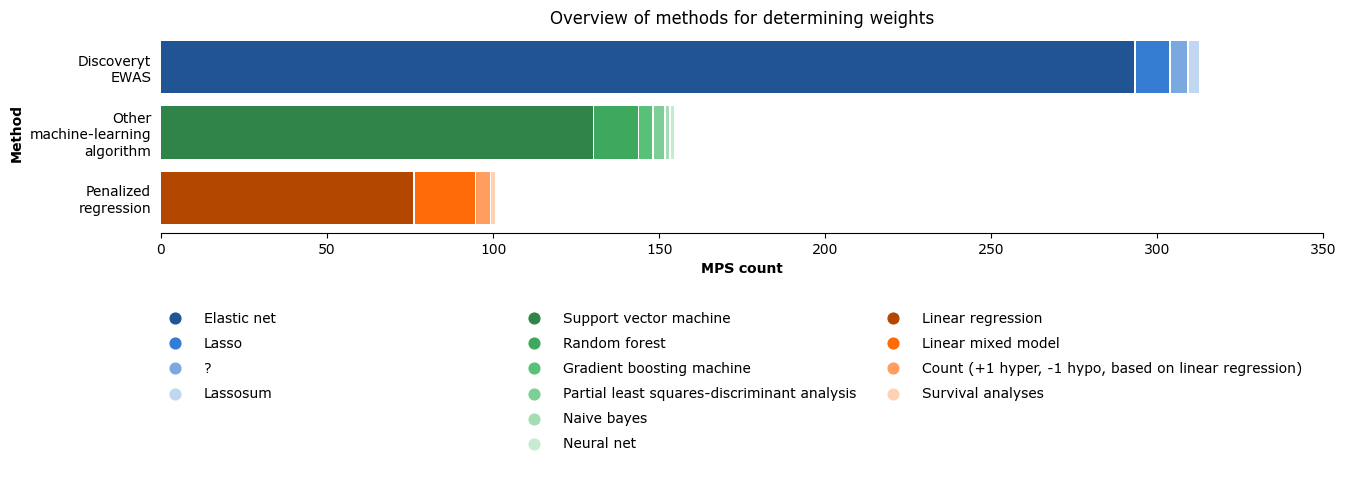

In [ ]:
mps_table.Determining_weights_1.value_counts()

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys 

def generate_palette(base_color, n, min_light=0.35, max_light=0.85):
    """Generate n visually distinct colors from a base color by varying lightness."""
    base = mcolors.to_rgb(base_color)
    colors = []
    h, l, s = colorsys.rgb_to_hls(*base)
    for i in range(n):
        # Interpolate lightness
        light = min_light + (max_light - min_light) * i / max(1, n-1)
        # Convert to HLS, change lightness, then back to RGB
        rgb = colorsys.hls_to_rgb(h, light, s)
        colors.append(rgb)
    return colors

# Explode Determining_weights_1 into two columns
weights_split = mps_table['Determining_weights_1'].dropna().str.split('|', expand=True)
weights_split.columns = ['Main', 'Sub']

# Clean up whitespace
weights_split['Main'] = weights_split['Main'].str.strip()
weights_split['Sub'] = weights_split['Sub'].str.strip()

# Count occurrences for stacking
stacked_counts = weights_split.groupby(['Main', 'Sub']).size().unstack(fill_value=0)

# Order the 'Sub' columns by total count (descending)
sub_order = stacked_counts.sum(axis=0).sort_values(ascending=False).index
stacked_counts = stacked_counts[sub_order]

# Assign a different colormap to each Main group
main_base_colors = ['#ff6600', '#3ca55c', '#205493']  # orange, green, blue

main_groups = stacked_counts.index.tolist()
colormaps = [plt.cm.Oranges_r,  plt.cm.Greens_r,  plt.cm.Blues_r,]

color_dict = {}
all_subs = stacked_counts.columns.tolist()
for i, main in enumerate(main_groups):
    subs_for_main = [sub for sub in all_subs if stacked_counts.loc[main, sub] > 0]
    palette = generate_palette(main_base_colors[i], len(subs_for_main))
    for j, sub in enumerate(subs_for_main):
        color_dict[(main, sub)] = palette[j]

    # cmap = colormaps[i]
    # n_subs = len(all_subs)
    # for j, sub in enumerate(all_subs):
    #     # Each sub-method gets a color from the colormap of its main group
    #     color_dict[(main, sub)] = cmap(j*j*2 -10)  # avoid too light colors

# Plot horizontal stacked bar plot with custom colors
fig, (ax, leg) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.3})

gap = 0.5
bottom = np.zeros(len(main_groups))
for idx, sub in enumerate(all_subs):
    vals = stacked_counts[sub].values
    color = [color_dict.get((main, sub), "#cccccc") for main in main_groups]
    # Add the gap * idx to the left position
    ax.barh(main_groups, vals, left=bottom, color=color, label=sub)
    vals_with_gap = vals.astype(float)
    vals_with_gap[vals != 0] += gap
    bottom += vals_with_gap 

ax.set_xlabel('MPS count', fontweight='bold')
ax.set_ylabel('Method', fontweight='bold')
ax.set_yticklabels(['Discovery\nEWAS','Other\nmachine-learning\nalgorithm','Penalized\nregression'])
ax.set_title('Overview of methods for determining weights')

ax.set_xlim(0, 350)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)

for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

n_main = len(main_groups)
x_gap = 2.5  # horizontal gap between columns

for i, main in enumerate(main_groups):
    # Get sub-methods with nonzero count for this main group
    subs_for_main = [sub for sub in all_subs if stacked_counts.loc[main, sub] > 0]
    for j, sub in enumerate(subs_for_main):
        y = j+1  # top-down
        x = i * x_gap + x_gap
        color = color_dict[(main, sub)]
        leg.scatter(x, y, color=color, s=60)
        leg.text(x - 0.2, y, sub, va='center', fontsize=10)

# Set limits for better spacing
max_rows = max([sum(stacked_counts.loc[main] > 0) for main in main_groups])
leg.set_xlim(-0.5, n_main * x_gap+ 0.1)
leg.set_ylim(0, max_rows + 2)
leg.invert_yaxis()
leg.invert_xaxis()
leg.axis('off')

fig.savefig(f'../static_output/Figure4B.png', dpi=300, bbox_inches='tight')
